In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 3.8MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from joblib import dump
from google.colab import files
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV

**Step 1.** Load dataset

Note: The 'census.csv' file was created using [U2_Build_Data_Wrangling.ipynb](https://colab.research.google.com/drive/1N_smUCm3c5zPi4yUCYwDkZpK2kq-FtJF?usp=sharing).

In [ ]:
# Load census dataset
file = '/content/census.csv'
census = pd.read_csv(file)

Step 2: Feature engineering


In [ ]:
# Total minority population of county (%)
census['Minority_pop'] = (census['Black'] + census['Hispanic'] + census['Asian'] + census['Native'] + census['Pacific'])

Step 3: Decision Tree model


In [ ]:
# Upsample to_spring_cat, train-val-test split
# Majority class (>50 mi) has 2632 samples
# Separate majority and minority classes
census_majority = census[census['to_spring_cat'] == '>50 mi']
census_minority1 = census[census['to_spring_cat'] == '<20 mi']
census_minority2 = census[census['to_spring_cat'] == '20-50 mi']

# Upsample minority class 1
census_minority_upsampled1 = resample(census_minority1,
                                     replace=True, # Sample with replacement
                                     n_samples=2632, # Match majority class
                                     random_state=42)
# Upsample minority class 2
census_minority_upsampled2 = resample(census_minority2,
                                     replace=True, # Sample with replacement
                                     n_samples=2632, # Match majority class
                                     random_state=42)

# Combine majority class with upsampled minority class
census_upsampled = pd.concat([census_majority, census_minority_upsampled1, census_minority_upsampled2])

# Train-Validation-Test split for to_spring_cat (classification)
target = 'to_spring_cat'
features = census.columns.drop([target, 'CountyId', 'closest_spring', 'has_spring', 'State', 'County', 'coordinates', 'Latitude', 'Longitude'])

X = census_upsampled[features]
y = census_upsampled[target]

# Split off test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Split off validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
# Decision tree model
dectree_model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=13))
dectree_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=13,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [ ]:
# Upsampled data (validation set): score, confusion matrix, precision/recall
print(f'Validation set score: {dectree_model.score(X_val, y_val)}')
print(f'Test set score: {dectree_model.score(X_test, y_test)}')
y_pred = dectree_model.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print('<20 mi')
precision = precision_score(y_val, y_pred, labels=['<20 mi'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(y_val, y_pred, labels=['<20 mi'], average='weighted')
print('Recall: %.3f' % recall)
print('20-50 mi')
precision = precision_score(y_val, y_pred, labels=['20-50 mi'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(y_val, y_pred, labels=['20-50 mi'], average='weighted')
print('Recall: %.3f' % recall)
print('>50 mi')
precision = precision_score(y_val, y_pred, labels=['>50 mi'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(y_val, y_pred, labels=['>50 mi'], average='weighted')
print('Recall: %.3f' % recall)

Validation set score: 0.9341355288157062
Test set score: 0.9316455696202531
[[521   2   0]
 [  2 509   4]
 [ 61  35 445]]
<20 mi
Precision: 0.932
Recall: 0.988
20-50 mi
Precision: 0.892
Recall: 0.996
>50 mi
Precision: 0.991
Recall: 0.823


In [ ]:
# Non-upsampled data (all data): score, confusion matrix, precision/recall
print(f'Score: {dectree_model.score(census[features], census[target])}')
y_pred = dectree_model.predict(census[features])
print(confusion_matrix(census[target], y_pred))
print('<20 mi')
precision = precision_score(census[target], y_pred, labels=['<20 mi'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(census[target], y_pred, labels=['<20 mi'], average='weighted')
print('Recall: %.3f' % recall)
print('20-50 mi')
precision = precision_score(census[target], y_pred, labels=['20-50 mi'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(census[target], y_pred, labels=['20-50 mi'], average='weighted')
print('Recall: %.3f' % recall)
print('>50 mi')
precision = precision_score(census[target], y_pred, labels=['>50 mi'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(census[target], y_pred, labels=['>50 mi'], average='weighted')
print('Recall: %.3f' % recall)

Score: 0.9140926640926641
[[ 276    1    0]
 [   1  197    1]
 [ 162  102 2368]]
<20 mi
Precision: 0.657
Recall: 0.990
20-50 mi
Precision: 0.629
Recall: 0.996
>50 mi
Precision: 1.000
Recall: 0.900


Step 6: Feature permutation

In [ ]:
# Feature permutation 
transformers = make_pipeline(StandardScaler())
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = DecisionTreeClassifier(max_depth=13)
model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=5,
    random_state=91)

permuter.fit(X_val_transformed, y_val)

# Show top N feature importances by weight
top=10
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()
eli5.show_weights(permuter,top=top,feature_names=feature_names)

Weight,Feature
0.2806 ± 0.0077,Drive
0.1967 ± 0.0149,Hispanic
0.1942 ± 0.0172,Black
0.1541 ± 0.0186,PublicWork
0.1516 ± 0.0079,MeanCommute
0.1262 ± 0.0142,IncomePerCap
0.0798 ± 0.0118,OtherTransp
0.0761 ± 0.0091,ChildPoverty
0.0706 ± 0.0078,WorkAtHome
0.0690 ± 0.0056,Construction


In [ ]:
# Remove features under certain importance level
min_importance = 0.1485
mask = permuter.feature_importances_ > min_importance
features = X_train.columns[mask]

# New train, val
X_train_drop_bad_features = X_train[features]
X_val_drop_bad_features = X_val[features]
X_test_drop_bad_features = X_test[features]

# Fit new decision tree and get score
dectree_model_permuted = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=13))
dectree_model_permuted.fit(X_train_drop_bad_features, y_train)
print(f'Validation set core: {dectree_model_permuted.score(X_val_drop_bad_features, y_val)}')
print(f'Test set score: {dectree_model_permuted.score(X_test_drop_bad_features, y_test)}')
list(features)

Validation set core: 0.9081697276757441
Test set score: 0.9050632911392406


['Hispanic', 'Black', 'Drive', 'MeanCommute', 'PublicWork']

[[500  11   4]
 [  8 512   3]
 [ 33  86 422]]


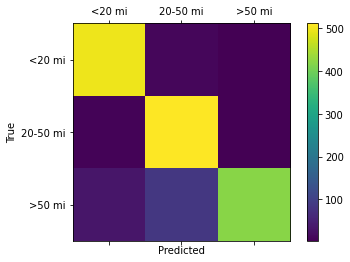

In [ ]:
# Confusion matrix after permutation (validation set)
y_pred = dectree_model_permuted.predict(X_val_drop_bad_features)
labels = ['<20 mi', '20-50 mi', '>50 mi']
cm = confusion_matrix(y_val, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Step 7: Parameter search

In [ ]:
# Parameter grid to search
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
# Random grid to search for best hyperparameters
# 5-fold cross validation, search across 80 different combinations, use all available cores
dc = DecisionTreeClassifier()
dc_random = RandomizedSearchCV(estimator = dc, param_distributions = random_grid, n_iter = 80, cv = 5, verbose=2, random_state=42, n_jobs = -1)
dc_random.fit(X_train_drop_bad_features, y_train)
dc_random.best_params_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.7s finished


{'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
# Decision Tree with feature permutation and parameter selection ** Using non-upsampled data ** 
dectree_model_best_params = make_pipeline(StandardScaler(), 
                                          DecisionTreeClassifier(max_depth=20,max_features='sqrt',min_samples_leaf=1,min_samples_split=2))

X = census[features]
y = census[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

dectree_model_best_params.fit(X_train, y_train)
print(f'Test set score: {dectree_model_best_params.score(X_test, y_test)}')

Test set score: 0.7572347266881029


In [ ]:
# Confusion matrix on whole dataset (not upsampled)
y_pred = dectree_model_best_params.predict(X)
y_prob = dectree_model_best_params.predict_proba(X)
print(confusion_matrix(y, y_pred))

[[ 232    9   36]
 [   9  160   30]
 [  35   20 2577]]


In [ ]:
# Precision and Recall on whole dataset (not upsampled)
print('<20 mi')
precision = precision_score(y, y_pred, labels=['<20 mi'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(y, y_pred, labels=['<20 mi'], average='weighted')
print('Recall: %.3f' % recall)
print('20-50 mi')
precision = precision_score(y, y_pred, labels=['20-50 mi'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(y, y_pred, labels=['20-50 mi'], average='weighted')
print('Recall: %.3f' % recall)
print('>50 mi')
precision = precision_score(y, y_pred, labels=['>50 mi'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(y, y_pred, labels=['>50 mi'], average='weighted')
print('Recall: %.3f' % recall)

<20 mi
Precision: 0.847
Recall: 0.804
20-50 mi
Precision: 0.841
Recall: 0.838
>50 mi
Precision: 0.975
Recall: 0.979


In [ ]:
# Specific prediction
n=245
test = np.array(X_test.iloc[n])
test = test.reshape((1,-1))
y_pred = dectree_model_best_params.predict(test)[0]
print('Prediction:', y_pred)
y_prob = dectree_model_best_params.predict_proba(test)[0]
print('Probability:', max(y_prob))
print('Actual:', y_test.iloc[n])

Prediction: <20 mi
Probability: 1.0
Actual: <20 mi


Step 8: Create df with releavant features, lat/lon, results for display on dash app

In [ ]:
# Small df with only features, target, results 
def wrangle(df, model):
  # Columns to include from original dataframe
  cols = ['Hispanic', 'Drive', 'MeanCommute', 'Black', 'PublicWork', 'Longitude', 'Latitude', 'to_spring_cat']
  # Columns used in model
  X = df[['Hispanic', 'Black', 'Drive', 'MeanCommute', 'PublicWork']]

  # Predictions
  y_pred = model.predict(X)
  # Maximum probabilty for each prediction
  y_prob = model.predict_proba(X)
  probs = []
  for i in range(len(y_prob)):
    probs.append(max(y_prob[i]))
  
  new = df[cols]
  # Add predictions
  new['Prediction'] = y_pred
  # Add column of preciction = correct/wrong
  correct = new['to_spring_cat'] == new['Prediction']
  new['Correct'] = correct
  # Add probabilities
  new['Probability'] = probs
  # Rename target variable column
  new.rename(columns={"to_spring_cat": "True"}, inplace=True)
  return new

wrangle_df = census.copy()
dash_df = wrangle(wrangle_df, dectree_model_best_params)

In [ ]:
# Display random sample of dash_df

n=12
sample = dash_df.sample(n=n)

fig = go.Figure(data=[go.Table(
    header=dict(values=list(sample.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[sample.Hispanic, sample.Drive, sample.MeanCommute, sample.Black, sample.PublicWork, sample.Longitude, sample.Latitude, sample['True'], sample.Prediction, sample.Correct, sample.Probability],
               fill_color='lavender',
               align='left'))
])
fig.show()

Step 9: Explore right and wrong predictions

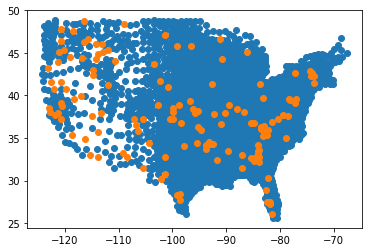

In [ ]:
# Only wrong predictions
wrong = dash_df[dash_df['Correct']==False]
# Only right predictions
right = dash_df[dash_df['Correct']==True]

plt.scatter(right['Longitude'], right['Latitude'])
plt.scatter(wrong['Longitude'], wrong['Latitude'])

(20, 11)

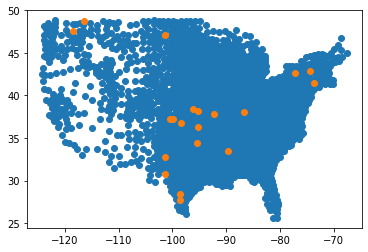

In [ ]:
# Costly predictions: predicting a close spring when none exists
bad_wrong = wrong[(wrong['Prediction']=='<20 mi') & (wrong['True']=='>50 mi')]
plt.scatter(right['Longitude'], right['Latitude'])
plt.scatter(bad_wrong['Longitude'], bad_wrong['Latitude'])
bad_wrong.shape

In [ ]:
wrong['Prediction'].value_counts()

>50 mi      66
20-50 mi    44
<20 mi      29
Name: Prediction, dtype: int64

In [ ]:
right['Prediction'].value_counts()

>50 mi      2577
20-50 mi     232
<20 mi       160
Name: Prediction, dtype: int64

Step 10: Export model for Dash app

In [ ]:
# Pickle model
dump(dectree_model_best_params, 'dectree.joblib', compress=True)

['dectree.joblib']

In [ ]:
files.download('dectree.joblib') 